In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
import bz2
import os
import pickle
import plotutils.plotutils as pu
import rebound as re
import seaborn
import sys

Populating the interactive namespace from numpy and matplotlib


/Users/farr/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
seaborn.set_style('ticks')

In [3]:
sim = re.Simulation()
sim.add(['Sun', 'Jupiter', 'Saturn', 'Uranus', 'Neptune'])
sim.add(m=3e-5, a=700, e=0.6, pomega=pi, l=random.uniform(low=0,high=2*pi)) # Perturber
sim.move_to_com()
sim.dt = 1.0
sim.integrator = 'whfast'
sim.integrator_whfast_safe_mode = 0
sim.integrator_whfast_corrector = 11
sim.status()

Searching NASA Horizons for 'Sun'... Found: Sun (10).
Searching NASA Horizons for 'Jupiter'... Found: Jupiter Barycenter (5).
Searching NASA Horizons for 'Saturn'... Found: Saturn Barycenter (6).
Searching NASA Horizons for 'Uranus'... Found: Uranus Barycenter (7).
Searching NASA Horizons for 'Neptune'... Found: Neptune Barycenter (8).
---------------------------------
REBOUND version:     	2.13.5
REBOUND built on:    	Feb 22 2016 15:29:40
Number of particles: 	6
Selected integrator: 	whfast
Simulation time:     	0.000000
Current timestep:    	1.000000
---------------------------------
<rebound.Particle object, id=0 m=1.0 x=-0.0289166548851 y=0.00656017653909 z=-0.000162341921026 vx=1.74220737969e-05 vy=0.00040219981453 vz=-9.56765284106e-07>
<rebound.Particle object, id=0 m=0.000954791915211 x=-5.31382196657 y=1.22838083673 z=0.113020128312 vx=-0.104119003869 vy=-0.406674602689 vz=0.00401950801287>
<rebound.Particle object, id=0 m=0.000285885672722 x=-3.48291162395 y=-9.39168878108 z=

In [4]:
Ntest = 1000
for i in range(Ntest):
    a = random.uniform(low=50, high=550)
    q = random.uniform(low=30, high=50)
    e = 1 - q/a
    pomega = random.uniform(low=0, high=2*pi)
    l = random.uniform(low=0, high=2*pi)
    sim.add(a=a, e=e, pomega=pomega, inc=0, l=l)
sim.N_active = sim.N - Ntest

In [5]:
%%time
with bz2.BZ2File('orbits.pkl.bz2', 'w') as out:
    for t in linspace(0, 2*pi*1000000*12, 1000):
        sim.integrate(t, exact_finish_time=0)
        print 'Integrated to ', sim.t
        orbs = sim.calculate_orbits()
        pickle.dump((sim.t, orbs), out)
        sim.save('temp.simulation')
        os.rename('temp.simulation', 'simulation.save')

Integrated to  0.0
Integrated to  75474.0
Integrated to  150948.0
Integrated to  226422.0
Integrated to  301895.0
Integrated to  377369.0
Integrated to  452843.0
Integrated to  528316.0
Integrated to  603790.0
Integrated to  679264.0
Integrated to  754737.0
Integrated to  830211.0
Integrated to  905685.0
Integrated to  981159.0
Integrated to  1056632.0
Integrated to  1132106.0
Integrated to  1207580.0
Integrated to  1283053.0
Integrated to  1358527.0
Integrated to  1434001.0
Integrated to  1509474.0
Integrated to  1584948.0
Integrated to  1660422.0
Integrated to  1735896.0
Integrated to  1811369.0
Integrated to  1886843.0
Integrated to  1962317.0
Integrated to  2037790.0
Integrated to  2113264.0
Integrated to  2188738.0
Integrated to  2264211.0
Integrated to  2339685.0
Integrated to  2415159.0
Integrated to  2490633.0
Integrated to  2566106.0
Integrated to  2641580.0
Integrated to  2717054.0
Integrated to  2792527.0
Integrated to  2868001.0
Integrated to  2943475.0
Integrated to  30189

In [25]:
orbs = []
ts = []
with bz2.BZ2File('orbits.pkl.bz2', 'r') as inp:
    try:
        while True:
            t, orb = pickle.load(inp)
            ts.append(t)
            orbs.append(orb)
    except EOFError:
        pass

(30, 1000, 0.0, 7.0)

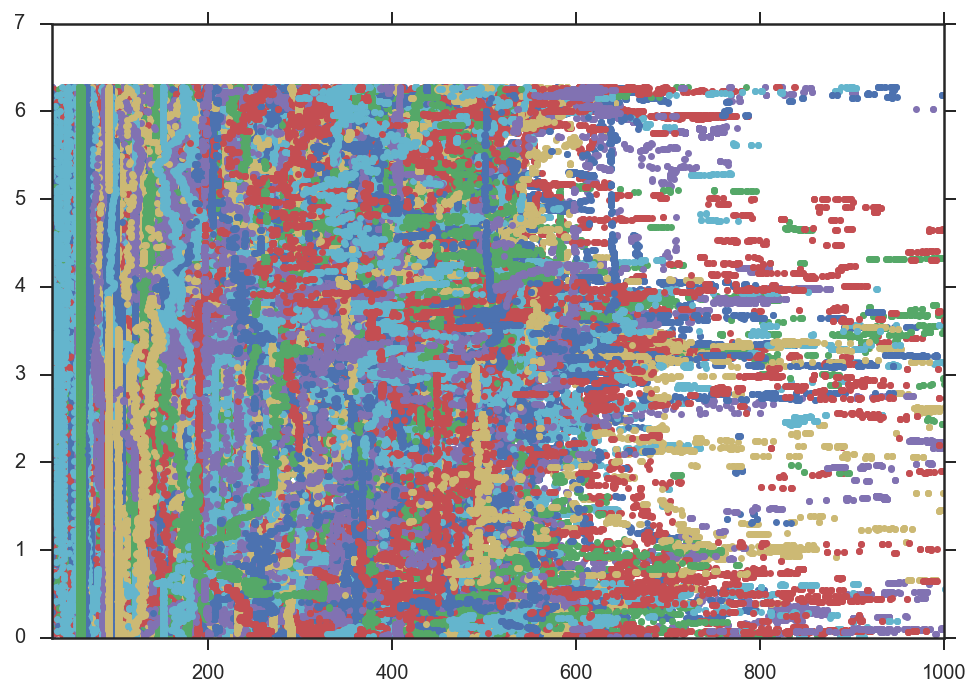

In [15]:
for i in range(len(orbs[0])):
    plot([o[i].a for o in orbs], [fmod(o[i].omega - o[4].omega+2*pi, 2*pi) for o in orbs], '.')
axis(xmin=30,xmax=1000)

(30, 1000, 0, 1)

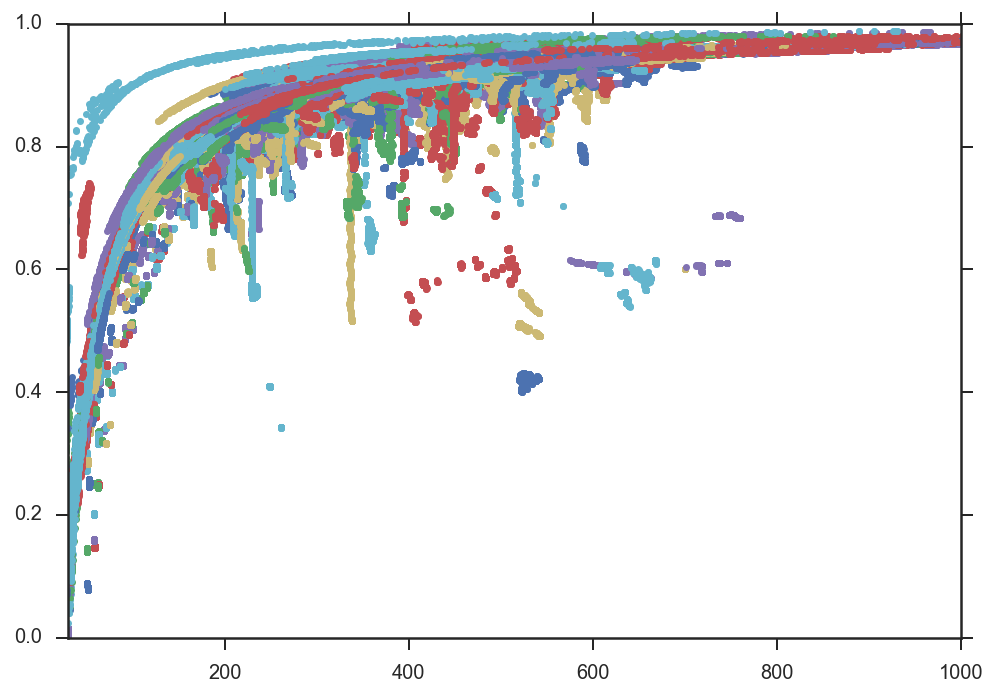

In [22]:
for i in range(len(orbs[0])):
    plot([o[i].a for o in orbs], [o[i].e for o in orbs], '.')
axis(xmin=30,xmax=1000, ymax=1, ymin=0)